<a href="https://colab.research.google.com/github/brillantescene/Capstone_Design/blob/master/cnn/soundee_major_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow import keras #import keras
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D

Using TensorFlow backend.


In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [4]:
import pathlib

In [5]:
from glob import glob

In [8]:
data_dir = tf.keras.utils.get_file(origin='https://github.com/brillantescene/Capstone_Design/raw/master/melspetrogram_img.tgz', 
                                   fname='images', extract=True)
data_dir = pathlib.Path(data_dir)

204619776/204612094 [==============================] - 2s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/images')

In [9]:
data_dir = pathlib.PosixPath("/root/.keras/datasets/melspetrogram_img")

In [10]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

4217

In [ ]:
!ls  /root/.keras/datasets/

images	melspetrogram_img


In [11]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

In [12]:
CLASS_NAMES

array(['water', 'drop', 'motor'], dtype='<U5')

tf.data(), train, validation, test split

In [13]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
#for f in list_ds.take(5):
#  print(f.numpy())

In [14]:
train_num = int(image_count * 0.7)
test_num = int(image_count * 0.2)
val_num = int(image_count * 0.1)

In [15]:
learning_rate = 0.001
training_epochs = 100
BATCH_SIZE = 64
IMG_HEIGHT = 224 #770
IMG_WIDTH = 224 #310
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(val_num/BATCH_SIZE)
TEST_STEPS = np.ceil(test_num/BATCH_SIZE)

In [16]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # 파일에서 raw data를 문자열로 로드
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
#for image, label in labeled_ds.take(1):
#  print("Image shape: ", image.numpy().shape)
#  print("Label: ", label.numpy())

In [18]:
train_ = labeled_ds.take(train_num)
test_ = labeled_ds.take(test_num)
val_ = labeled_ds.take(val_num)

In [19]:
train_
test_
val_

<TakeDataset shapes: ((224, 224, 3), (3,)), types: (tf.float32, tf.bool)>

In [20]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [21]:
train_ds = prepare_for_training(train_)
test_ds = prepare_for_training(test_)
val_ds = prepare_for_training(val_)

In [ ]:
train_ds
test_ds
val_ds

<PrefetchDataset shapes: ((None, 310, 770, 3), (None, 5)), types: (tf.float32, tf.bool)>

model

In [25]:
def AcousticSoundModel():
  inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  conv1 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(inputs)
  drop1 = Dropout(rate=0.2)(conv1)
  pool1 = MaxPool2D(padding='SAME')(drop1)

  conv2 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool1)
  drop2 = Dropout(rate=0.2)(conv2)
  pool2 = MaxPool2D(padding='SAME')(drop2)

  conv3 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool2)
  drop3 = Dropout(rate=0.2)(conv3)
  pool3 = MaxPool2D(padding='SAME')(drop3)

  pool3_flat = keras.layers.Flatten()(pool3)
  dense4 = Dense(units=128, activation=tf.nn.relu)(pool3_flat)
  logits = Dense(units=3, activation=tf.nn.sigmoid)(dense4)

  return keras.Model(inputs=inputs, outputs=logits)

In [26]:
model = AcousticSoundModel()

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['acc'])

In [28]:
model_dir = './model' #경로 설정은 이따가 제대로
    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [29]:
checkpoint_path = model_dir + '/soundee_classification.model'
checkpoint_dir = os.path.dirname(checkpoint_path)# Create a callback that saves the model's weights
cp = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                        monitor='val_loss', mode='min', save_best_only=True, 
                                        verbose=1)

In [30]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [31]:
callback = [es, cp]

In [32]:
hist = model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=training_epochs,
      batch_size = BATCH_SIZE,
      validation_data=val_ds,
      validation_steps=VALIDATION_STEPS,
      callbacks=callback)

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 0.2276 - acc: 0.9105
Epoch 00001: val_loss improved from inf to 0.01928, saving model to ./model/soundee_classification.model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/soundee_classification.model/assets
66/66 [==============================] - 32s 488ms/step - loss: 0.2276 - acc: 0.9105 - val_loss: 0.0193 - val_acc: 0.9955
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.0137 - acc: 0.9960
Epoch 00002: val_loss improved from 0.01928 to 0.01002, saving model to ./model/soundee_classification.model
INFO:tensorflow:Assets written to: ./model/soundee_classification.model/assets
66/66 [==============================] - 26s 394ms/step - loss: 0.0137 - acc: 0.9960 - val_loss: 0.0100 - val_acc: 1.0000
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 0.0022 - acc: 0.9998
Epoch 00003: val_loss improved fr

In [ ]:
!ls {checkpoint_dir} # 저장된 checkpoint 확인하기

checkpoint
soundee_classification.model.data-00000-of-00002
soundee_classification.model.data-00001-of-00002
soundee_classification.model.index


In [ ]:
#model.save_weights('saveweights', save_format='tf')

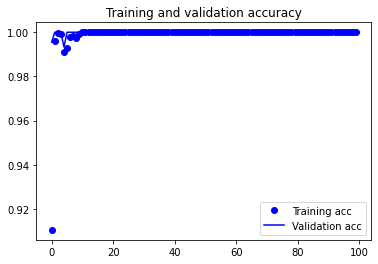

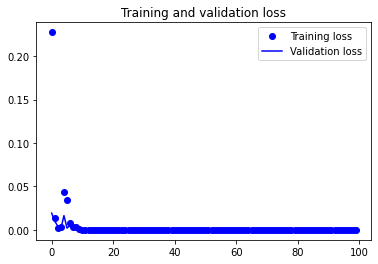

In [33]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
loss, acc = model.evaluate(test_ds, batch_size=BATCH_SIZE, steps=TEST_STEPS)
print('acc: %.2f%%, loss: %f'% (acc*100, loss))

14/14 [==============================] - 1s 100ms/step - loss: 2.9685e-04 - acc: 1.0000
acc: 100.00%, loss: 0.000297


prediction test

In [35]:
from PIL import Image
#import os, glob, numpy as np
from keras.models import load_model

In [36]:
test_dir = tf.keras.utils.get_file(origin='https://docs.google.com/uc?export=download&id=1VMllFJGjUwTScLMSpYJAR7gqjtQGu7fH', 
                                   fname='test', extract=True)
test_dir = pathlib.Path(test_dir)

983040/978684 [==============================] - 0s 0us/step


In [ ]:
#test_dir = pathlib.PosixPath("/root/.keras/datasets/DATASET")

In [37]:
test_dir = "/root/.keras/datasets/DATASET"

In [38]:
X = []
filenames = []
files = glob(test_dir+"/*.png")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X, dtype=np.float32)

In [39]:
files[:16]

['/root/.keras/datasets/DATASET/MOTOR_2.png',
 '/root/.keras/datasets/DATASET/MOTOR_5.png',
 '/root/.keras/datasets/DATASET/WATER_3.png',
 '/root/.keras/datasets/DATASET/MOTOR_0.png',
 '/root/.keras/datasets/DATASET/DROP_5.png',
 '/root/.keras/datasets/DATASET/DROP_1.png',
 '/root/.keras/datasets/DATASET/MOTOR_1.png',
 '/root/.keras/datasets/DATASET/DROP_2.png',
 '/root/.keras/datasets/DATASET/WATER_0.png',
 '/root/.keras/datasets/DATASET/WATER_4.png',
 '/root/.keras/datasets/DATASET/DROP_4.png',
 '/root/.keras/datasets/DATASET/WATER_2.png',
 '/root/.keras/datasets/DATASET/DROP_0.png',
 '/root/.keras/datasets/DATASET/WATER_5.png',
 '/root/.keras/datasets/DATASET/WATER_1.png',
 '/root/.keras/datasets/DATASET/MOTOR_3.png']

In [40]:
prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [ ]:
filenames[12].split('/')

['', 'root', '.keras', 'datasets', 'DATASET', 'DROP_3.png']

In [41]:
cnt = 0
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "motor"
    elif pre_ans == 1: pre_ans_str = "water"
    elif pre_ans == 2: pre_ans_str = "drop"
    #elif pre_ans == 3: pre_ans_str = "baby"
    #else: pre_ans_str = "dog"

    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split('/')[5]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split('/')[5]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split('/')[5]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    #if i[3] >= 0.8: print("해당 "+filenames[cnt].split('/')[5]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    #if i[4] >= 0.8: print("해당 "+filenames[cnt].split('/')[5]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[0] < 0.8 and i[1] < 0.8 and i[2] < 0.8 : print("추정할 수 없습니다.")
    print()
    cnt += 1

[0.000 1.000 0.000]
해당 MOTOR_2.png이미지는 water로 추정됩니다.

[0.000 0.000 1.000]
해당 MOTOR_5.png이미지는 drop로 추정됩니다.

[1.000 0.000 0.000]
해당 WATER_3.png이미지는 motor로 추정됩니다.

[0.000 1.000 1.000]
해당 MOTOR_0.png이미지는 water로 추정됩니다.
해당 MOTOR_0.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_5.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_1.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 MOTOR_1.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_2.png이미지는 water로 추정됩니다.

[1.000 0.000 0.000]
해당 WATER_0.png이미지는 motor로 추정됩니다.

[1.000 0.000 0.000]
해당 WATER_4.png이미지는 motor로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_4.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 WATER_2.png이미지는 water로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_0.png이미지는 water로 추정됩니다.

[1.000 0.000 0.000]
해당 WATER_5.png이미지는 motor로 추정됩니다.

[0.000 0.000 0.000]
추정할 수 없습니다.

[0.000 0.000 1.000]
해당 MOTOR_3.png이미지는 drop로 추정됩니다.

[0.000 1.000 0.000]
해당 DROP_3.png이미지는 water로 추정됩니다.

[0.000 0.000 1.000]
해당 MOTOR_4.png이미지는 drop로 추정됩니다.



In [ ]:
output = model.predict(test_ds, steps=TEST_STEPS)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(output)

In [ ]:
for i in output:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    #print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "motor"
    elif pre_ans == 1: pre_ans_str = "water"
    elif pre_ans == 2: pre_ans_str = "drop"
    elif pre_ans == 3: pre_ans_str = "baby"
    else: pre_ans_str = "dog"

    if i[0] >= 0.8 : print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #else : print("추정하지 못했습니다.")
    if i[1] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #else : print("추정하지 못했습니다.")
    if i[2] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #else : print("추정하지 못했습니다.")
    if i[3] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #else : print("추정하지 못했습니다.")
    if i[4] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    #else : print("추정하지 못했습니다.")

In [ ]:
from PIL import Image
#import os, glob, numpy as np
from keras.models import load_model

In [ ]:
test_dir = "./multi_img_data/imgs_others_test" #test 이미지 넣어둔 디렉토리 경로. git에서 받아와서 설정하면됨

In [ ]:
model = load_model('soundee_classification.model')

In [ ]:
test_model = AcousticSoundModel()

In [ ]:
test_model.load_weights(checkpoint_path)

In [ ]:
X[1]

In [ ]:
filenames[:10]

['/root/.keras/datasets/DATASET/DROP_0.png',
 '/root/.keras/datasets/DATASET/MOTOR_2.png',
 '/root/.keras/datasets/DATASET/WATER_0.png',
 '/root/.keras/datasets/DATASET/WATER_1.png',
 '/root/.keras/datasets/DATASET/MOTOR_0.png',
 '/root/.keras/datasets/DATASET/WATER_2.png',
 '/root/.keras/datasets/DATASET/MOTOR_1.png',
 '/root/.keras/datasets/DATASET/DROP_2.png',
 '/root/.keras/datasets/DATASET/DROP_1.png']

In [ ]:
path = test_dir[0]

In [ ]:
image_pil = Image.open(path)
image = np.array(image_pil)

In [ ]:
image.shape

(770, 310, 4)

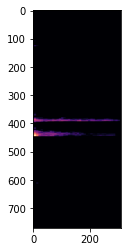

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
test = tf.data.Dataset.list_files(str(test_dir/'*'))
test = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test = prepare_for_training(test)

In [ ]:
prediction = model.predict(test, steps=TEST_STEPS)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(output)

[[1.000 0.000 0.000]
 [0.000 0.000 0.249]
 [1.000 0.000 0.000]
 ...
 [0.000 0.000 0.894]
 [0.000 0.000 0.008]
 [1.000 0.000 0.000]]


In [ ]:
filenames = tf.data.Dataset.list_files(str(test_dir/'*'))
for f in filenames.take(8):
  print(f.numpy())

b'/root/.keras/datasets/DATASET/WATER_0.png'
b'/root/.keras/datasets/DATASET/MOTOR_1.png'
b'/root/.keras/datasets/DATASET/MOTOR_2.png'
b'/root/.keras/datasets/DATASET/DROP_0.png'
b'/root/.keras/datasets/DATASET/MOTOR_0.png'
b'/root/.keras/datasets/DATASET/WATER_1.png'
b'/root/.keras/datasets/DATASET/DROP_1.png'
b'/root/.keras/datasets/DATASET/DROP_2.png'


In [ ]:
cnt = 0
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "motor"
    elif pre_ans == 1: pre_ans_str = "water"
    else: pre_ans_str = "drop"
    if i[0] >= 0.8 : print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[2] >= 0.8: print("해당 이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1

In [ ]:
cnt = 0
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "motor"
    elif pre_ans == 1: pre_ans_str = "water"
    else: pre_ans_str = "drop"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1

[1.000 0.000 0.000]
0


IndexError: ignored

In [ ]:
image_w = 64
image_h = 64
pixels = image_h * image_w * 3

X = []
filenames = []

In [ ]:
files = test_dir.glob('/*.png')

In [ ]:

#model = load_model('./model/soundee_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "motor"
    elif pre_ans == 1: pre_ans_str = "drop"
    elif pre_ans == 2: pre_ans_str = "water"
    elif pre_ans == 3: pre_ans_str = "babycrying"
    else: pre_ans_str = "dog"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

UnboundLocalError: ignored